In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import transformers 
import numpy as np
import torch
import datasets

import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

import sys

sys.path.insert(0, '..')

from decompose_bert import BertForSequenceClassificationDecomposed
from build_masks import build_masks_with_other
import preprocess_input


### Load Model

In [2]:
labels = ['awareness', 'changes_location', 'changes_state',
       'changes_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

path = "../../combined_SPRL_models/bert-large-cased"

decomposed_model = BertForSequenceClassificationDecomposed.from_pretrained(
    pretrained_model=path,
    debug=False, 
    num_labels=len(labels) * 3
    )

tokenizer = transformers.AutoTokenizer.from_pretrained(path + "/tokenizer")


### Load Data

In [3]:
roles_wide = pd.read_csv("../../../dataV2/combined_V1_V2.csv", na_filter=False)
roles_wide.drop("Unnamed: 0", inplace=True, axis=1)

roles_wide.rename({"Sentence": "sentence", "Arg.Phrase": "arg"}, axis=1, inplace=True)

properties_list = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

print(roles_wide.shape)
roles_wide["combined_labels"] = roles_wide["combined_labels"].apply(lambda x: eval(x))
roles_wide.head()


(28816, 17)


,Sentence.ID,Roleset,Gram.Func,sentence,Predicate,Split,arg,Arg.Stripped,Arg,arg_idx,verb_idx,structure,decomp_version,Pred.Lemma,modified_sentence,combined_labels,VN_mappings
0,0003_21,impose.01,nsubj,"In July , a gradual ban was imposed by the Env...",was imposed by,test,a gradual ban,a ban,1,"(3, 6)","(6, 9)",passive_full,V1,impose,1,"[1.0, 1.0, 3.0, 1.0, 5.0, 1.0, 5.0, 1.0, 1.0, ...",
1,0003_21,impose.01,dobj,"In July , a gradual ban was imposed by the Env...",was imposed by,train,the Environmental Protection Agency,the Environmental Protection Agency,0,"(9, 13)","(6, 9)",passive_full,V1,impose,1,"[5.0, 1.0, 3.0, 1.0, 5.0, 5.0, 5.0, 5.0, 1.0, ...",
2,0003_29,have.03,nsubj,No bearing on our work force today is had by it .,is had by,train,No bearing on our work force today,no bearing,1,"(0, 7)","(7, 10)",passive_full,V1,have,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",
3,0003_29,have.03,dobj,No bearing on our work force today is had by it .,is had by,test,it,It,0,"(10, 11)","(7, 10)",passive_full,V1,have,1,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 3.0, 2.0, ...",
4,0003_9,lead.02,nsubj,A team of researchers from the National Cancer...,was led by,train,A team of researchers from the National Cancer...,a team,1,"(0, 19)","(19, 22)",passive_full,V1,lead,1,"[5.0, 3.0, 3.0, 1.0, 3.0, 3.0, 5.0, 3.0, 1.0, ...",


In [4]:
eval_df = roles_wide.loc[
    (roles_wide["decomp_version"] == "V2") & \
    (roles_wide["Split"] == "test")
    # (roles_wide["modified_sentence"] == 0)
    ][["Pred.Lemma", "Gram.Func", "structure", "sentence", "Predicate", "arg_idx", "verb_idx", "arg", "Arg.Stripped"]].drop_duplicates().reset_index()

print(eval_df.shape)
eval_df


(639, 10)


,index,Pred.Lemma,Gram.Func,structure,sentence,Predicate,arg_idx,verb_idx,arg,Arg.Stripped
0,14299,raise,nsubj,active_full,A girl raises her hand .,raises,"(0, 2)","(2, 3)",A girl,A girl
1,14301,raise,dobj,active_full,A girl raises her hand .,raises,"(3, 5)","(2, 3)",her hand,the hand
2,14303,be,nsubj,active_full,""" I 'm afraid not , "" explains Winston , "" tha...",is,"(11, 12)","(12, 13)",that,that
3,14305,say,nsubj,active_full,"In a timid voice , he says : "" If an airplane ...",says,"(5, 6)","(6, 7)",he,he
4,14307,beam,nsubj,active_full,""" Wonderful ! "" Winston beams .",beams,"(4, 5)","(5, 6)",Winston,Winston
...,...,...,...,...,...,...,...,...,...,...
634,21898,enjoy,nsubj,passive_full,The animations were enjoyed by me and wanted t...,were enjoyed by,"(0, 2)","(2, 5)",The animations,the animations
635,21900,have,nsubj,passive_full,A Full Color Catalog and Wholesale Price List ...,is had by,"(0, 14)","(14, 17)",A Full Color Catalog and Wholesale Price List ...,a Color Catalog and Price List
636,21902,have,dobj,passive_full,A Full Color Catalog and Wholesale Price List ...,is had by,"(17, 18)","(14, 17)",us,We
637,21904,accecpt,nsubj,passive_full,"Visa , MasterCard , Amex , Dinner s Club / Car...",are accecpted by,"(0, 19)","(19, 22)","Visa , MasterCard , Amex , Dinner s Club / Car...",Visa MasterCard Amex the Club / Carte Blanche ...


### Make Contribution Masks and Process Sentences

In [15]:
dataset, eval_df, lengths = build_masks_with_other(eval_df, tokenizer).values()

print(max(lengths))
eval_df.head()


[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] her hand [PAD] [PAD]

arg:  her hand
stripped arg:  the hand
arg reconstructed (no mod):  hand
mod reconstructed:  her
[PAD] A girl [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] SPACE. com [PAD] [PAD]
Warning! not equal:	SPACE.com SPACE. com
Warning! not equal:	SPACE.com SPACE. com
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] Kistler [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

arg:  Our plans
stripped arg:  the plans
arg reconstructed (no mod):  plans
mod reconstructed:  Our
Warning! not equal:	Walter LTS co-founder and Chairman Walter LTS co - f

,index,sentence,structure,gram,contribution,mask
0,14299,<a>A girl<a><p> raises<p> her hand.,active_full,nsubj,arg_nomod_mask,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,14301,A girl<p> raises<p><a> her hand<a>.,active_full,dobj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [16]:
max_length = 128

def tokenize_and_mask(t):
    encoded = tokenizer(t["sentence"], padding="max_length", truncation=True,
                        max_length=max_length, return_tensors="pt")
    beta_mask = np.pad(t["mask"], (0, max_length - len(t["mask"])%max_length), 'constant')
    beta_mask = torch.Tensor(beta_mask).to(int)
    beta_mask = torch.stack([beta_mask, 1 - beta_mask])
    encoded["beta_mask"] = beta_mask
    return encoded

test_set = datasets.Dataset.from_pandas(eval_df)
test_set = test_set.map(tokenize_and_mask)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/2556 [00:00<?, ? examples/s]

In [17]:
gen = test_set.iter(batch_size=8)
with torch.no_grad():
    for i, batch in enumerate(gen):
        beta_mask = torch.Tensor(batch["beta_mask"]).to(torch.int32)
        input_ids = torch.Tensor(batch["input_ids"]).to(torch.int32).squeeze(1)

        l = decomposed_model(input_ids=input_ids,
                            beta_mask=beta_mask,
                            num_contributions=2).numpy()
        np.save(f"gcd_logits/bert-large-cased/batch_{i}_logits.npy", l)
        if i % 10 == 0:
            print(i)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310


### Analyze Contributions


In [18]:
logits = []
for i in range(320):
    a = np.load(f"gcd_logits/bert-large-cased/batch_{i}_logits.npy")
    logits.append(a)

logits = np.concatenate(logits, axis=1).reshape(3, -1, 3, 10)
binary_logits = preprocess_input.split_pos_neg_contributions(logits)

# # normalize over properties
# logits = logits - logits.mean((0, 1, 2), keepdims=True)
# logits = logits / logits.std((0, 1, 2), keepdims=True)


(3, 2556, 2, 10)


In [19]:
contributions_df = eval_df.copy(deep=True)

contributions_df["beta_contribution"] = (binary_logits[0] / (binary_logits[:2].sum(0).sum(1, keepdims=True) + 1e-10)).tolist()

contributions_df["span_length"] = contributions_df["mask"].apply(lambda x: x.astype(int).sum()).replace(0, np.nan)
contributions_df.dropna(subset="span_length", inplace=True)

contributions_df["beta_contribution"] = contributions_df.apply(
    lambda x: np.array(x["beta_contribution"])/x["span_length"],
    axis=1,
)

contributions_df.head()   


,index,sentence,structure,gram,contribution,mask,beta_contribution,span_length
0,14299,<a>A girl<a><p> raises<p> her hand.,active_full,nsubj,arg_nomod_mask,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[[-0.0, -0.0, 0.026101200896033582, 0.28717566...",2.0
1,14301,A girl<p> raises<p><a> her hand<a>.,active_full,dobj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0....",1.0
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[[0.4631736158353554, 0.17459440163344295, 0.4...",1.0
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[-0.0, -0.0, 0.13869231474088597, -0.0, -0.0,...",1.0
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[[-0.0, -0.0, 0.056758742341384984, -0.0, -0.0...",1.0


In [20]:
contributions_df[labels] = contributions_df['beta_contribution'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

contributions_df = contributions_df.melt(
    id_vars=["sentence", "index", "contribution", "gram", "structure"], value_vars=labels, value_name="logits",
    var_name="property")
contributions_df[["negative", "positive"]] = contributions_df['logits'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

spans = {
    "arg_nomod": "argument",
    "arg_mod": "modifier",
    "pred": "predicate",
    "other_args": "other_arguments"
}
contributions_df["span"] = contributions_df["contribution"].apply(
    lambda x: spans["_".join(x.split("_")[:-1])])
contributions_df = contributions_df.melt(id_vars=[ "index", "sentence","span", "property", "gram", "structure"],
                      value_vars=["negative", "positive"],
                      var_name="class", value_name="per_token_contribution")

contributions_df["structure"] = contributions_df["structure"].apply(
    lambda x: "_".join(x.split("_")[:-1]))
contributions_df["proto-role property"] = contributions_df["property"].apply(
    lambda x: "proto-patient" if x in ["changes_state", "changes_location", "changes_possession"] else "proto-agent"
)
contributions_df["position"] = contributions_df.apply(
    lambda x: "agent" if (
            x["gram"] == "nsubj" and x["structure"] == "active"
        ) or (
            x["gram"] == "dobj" and x["structure"] == "passive")
        else "patient",
    axis=1
)

contributions_df.head()


,index,sentence,span,property,gram,structure,class,per_token_contribution,proto-role property,position
0,14299,<a>A girl<a><p> raises<p> her hand.,argument,awareness,nsubj,active,negative,-0.000000,proto-agent,agent
1,14301,A girl<p> raises<p><a> her hand<a>.,argument,awareness,dobj,active,negative,-0.000000,proto-agent,patient
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",argument,awareness,nsubj,active,negative,0.463174,proto-agent,agent
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",argument,awareness,nsubj,active,negative,-0.000000,proto-agent,agent
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",argument,awareness,nsubj,active,negative,-0.000000,proto-agent,agent


In [21]:
percentiles_df = []
n = 20

for span in ["argument", "modifier", "predicate"]:
    for polarity in ["positive", "negative"]:
        for p in np.arange(n + 1) * (100/n):
            x = np.nanpercentile(
            contributions_df.loc[(contributions_df["span"] == span) & (contributions_df["class"] == polarity)]["per_token_contribution"].to_numpy(),
            [p])[0]

            percentiles_df.append({
                "span": span,
                "percentile": p,
                "stat": x,
                "class": polarity,
            })

percentiles_df = pd.DataFrame(percentiles_df).pivot(index="percentile", values=["stat"], columns=["span", "class"])
percentiles_df


stat                                                  
span        argument            modifier           predicate          
class       positive  negative  positive  negative  positive  negative
percentile                                                            
0.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
5.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
10.0       -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000
15.0        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
20.0       -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000
25.0        0.000000  0.000000  0.000000  0.000000  0.002854  0.000000
30.0        0.010774 -0.000000 -0.000000 -0.000000  0.016566 -0.000000
35.0        0.030219  0.000000  0.000000  0.000044  0.034159  0.000000
40.0        0.051190 -0.000000  0.000963  0.007358  0.054354 -0.000000
45.0        0.076984  0.000000  0.005959  0.014231  0.074951  0.000000
50.0        0.098667 -0.000000  0.012880  0.021854  0.094040 -0.000000
55.0        0.125373  0.011450  0.020429  0.030249  0.114964  0.000264
60.0        0.161853  0.032060  0.028548  0.039465  0.133484  0.018669
65.0        0.202919  0.055631  0.037950  0.049963  0.153028  0.040108
70.0        0.243618  0.081825  0.047712  0.064070  0.173027  0.060302
75.0        0.303082  0.110653  0.064279  0.082150  0.205602  0.084128
80.0        0.379991  0.147376  0.087011  0.104185  0.259390  0.116907
85.0        0.444114  0.198989  0.126573  0.131510  0.334098  0.160478
90.0        0.495547  0.259075  0.183004  0.184484  0.412276  0.226680
95.0        0.585689  0.350695  0.329190  0.263932  0.475029  0.341351
100.0       0.957945  0.866531  0.853980  0.769118  0.971044  0.954089

In [22]:
# lower, upper = np.nanpercentile(contributions_df["per_token_contribution"].to_numpy(), [0, 95])
# print(f"clipping outliers less than {lower} or greater than {upper}")
# contributions_df["per_token_contribution"] = contributions_df["per_token_contribution"].apply(
#     lambda x: np.clip(x, a_min=lower, a_max=upper)
# )

contributions_df.to_csv("bert_gcd_contributions.csv")


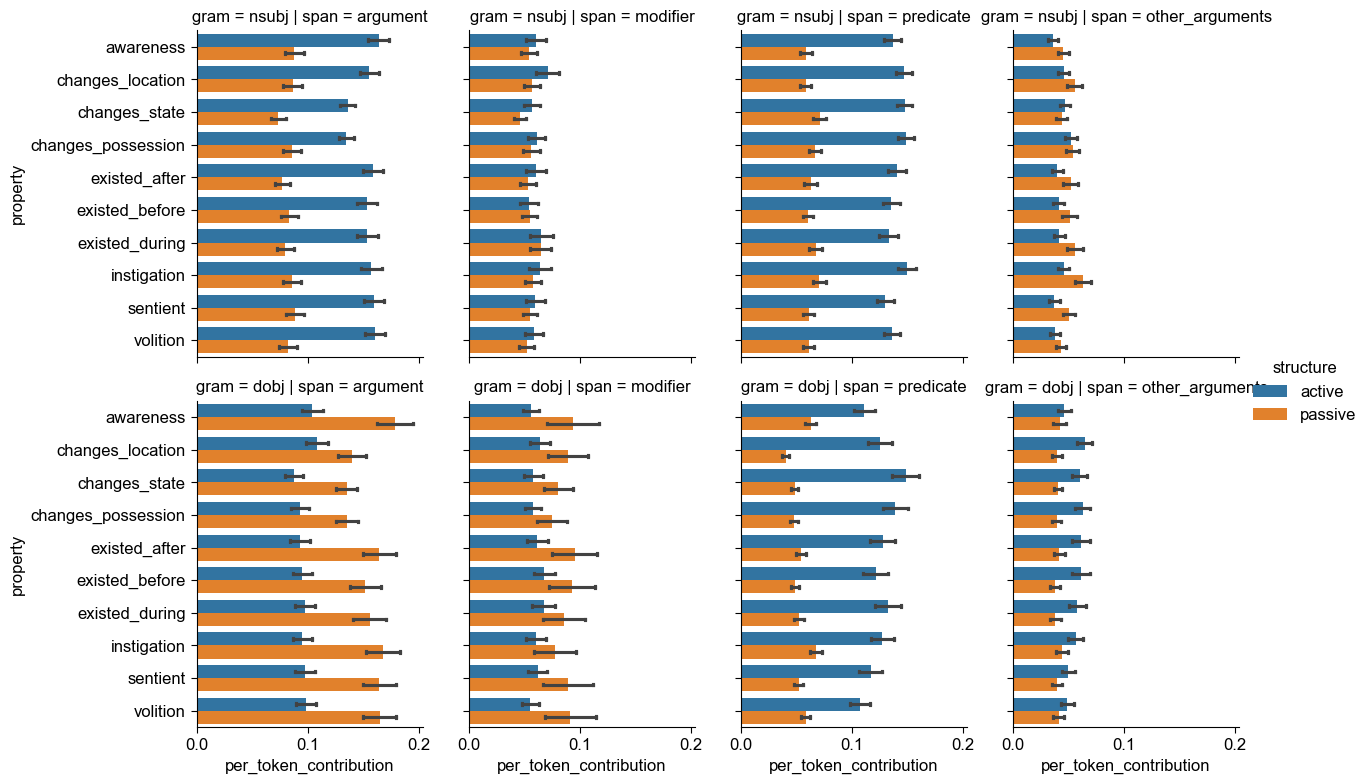

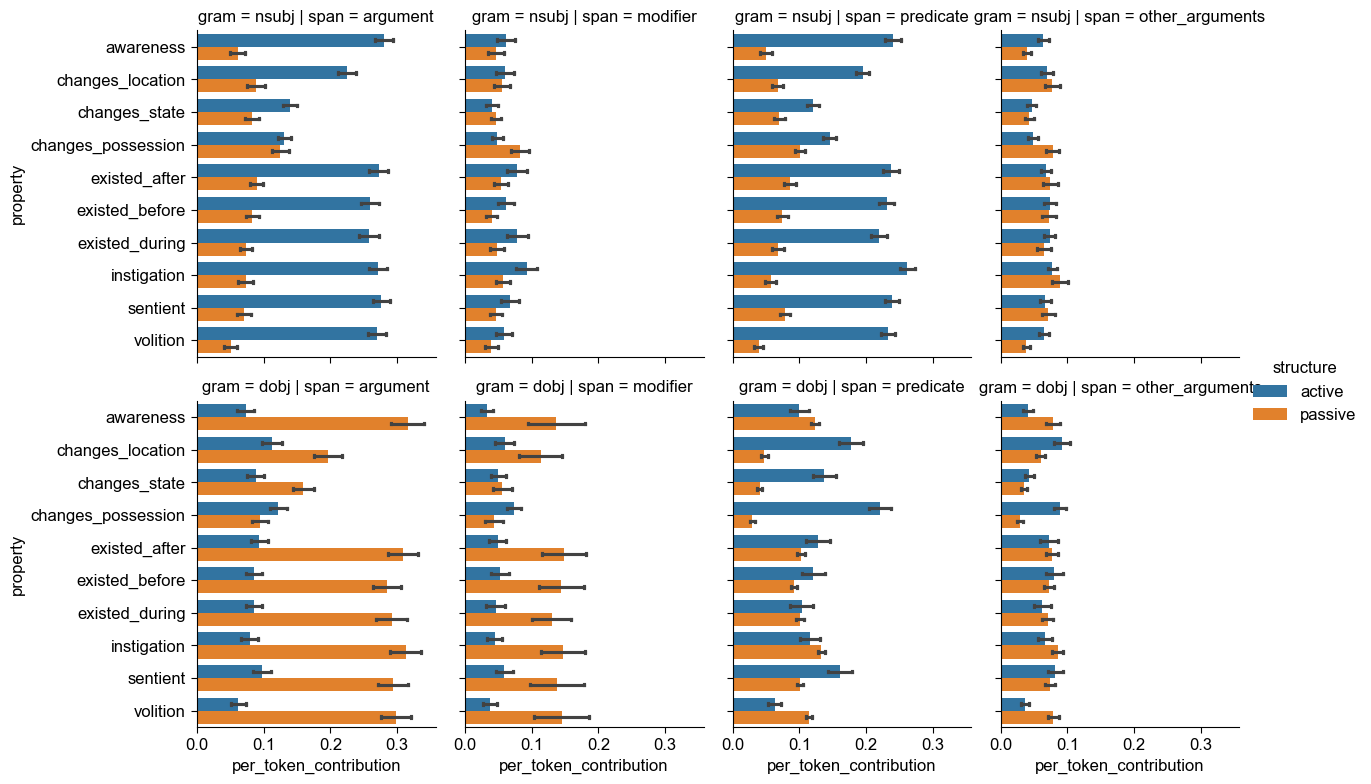

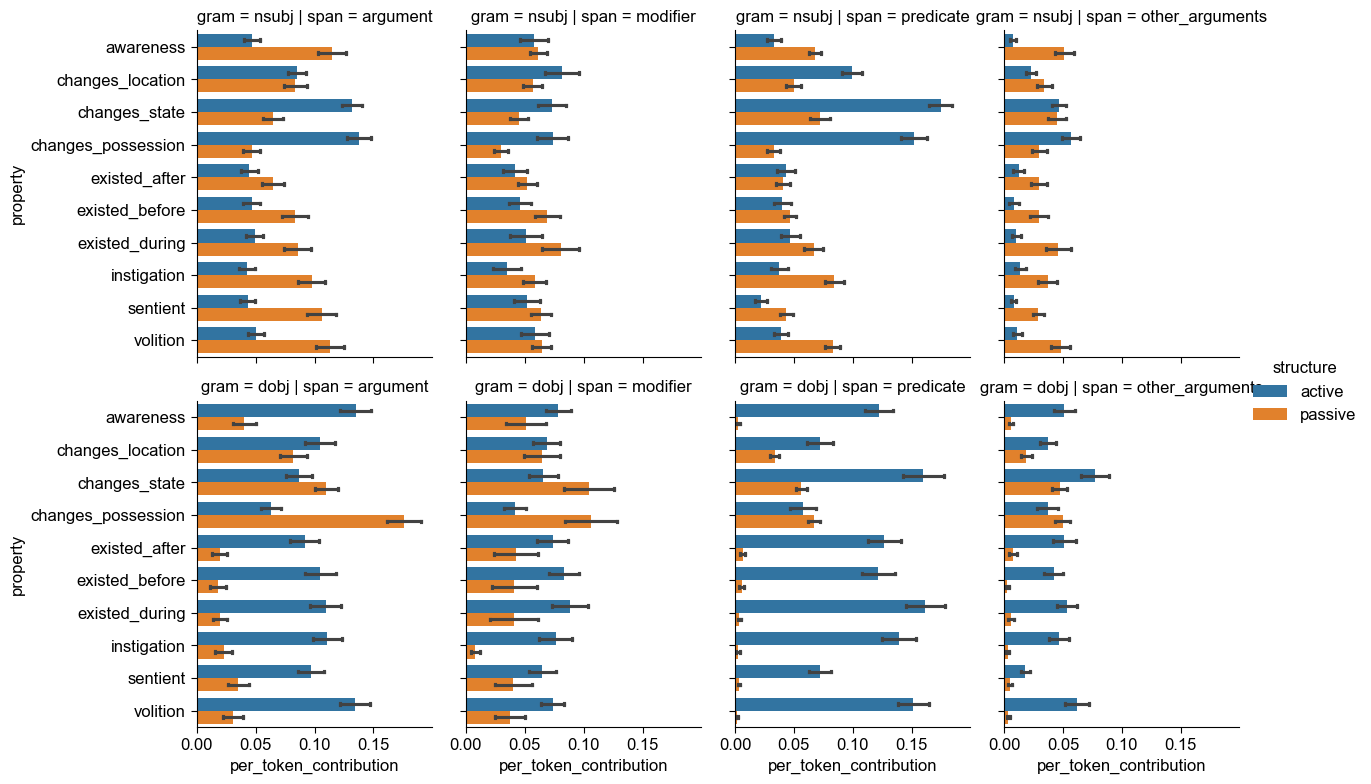

In [23]:
sns.catplot(
    contributions_df.loc[contributions_df["gram"] != "iobj"], col="span", kind="bar", hue="structure", orient="h", row="gram",
    y = "property", x = "per_token_contribution", errorbar="se", height=4, capsize=0.1,
    aspect=0.8)

sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["class"] == "positive")], col="span", kind="bar", hue="structure", orient="h", row="gram",
    y = "property", x = "per_token_contribution", errorbar="se", height=4, capsize=0.1,
    aspect=0.8)

sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["class"] == "negative")], col="span", kind="bar", hue="structure", orient="h", row="gram",
    y = "property", x = "per_token_contribution", errorbar="se", height=4, capsize=0.1,
    aspect=0.8)



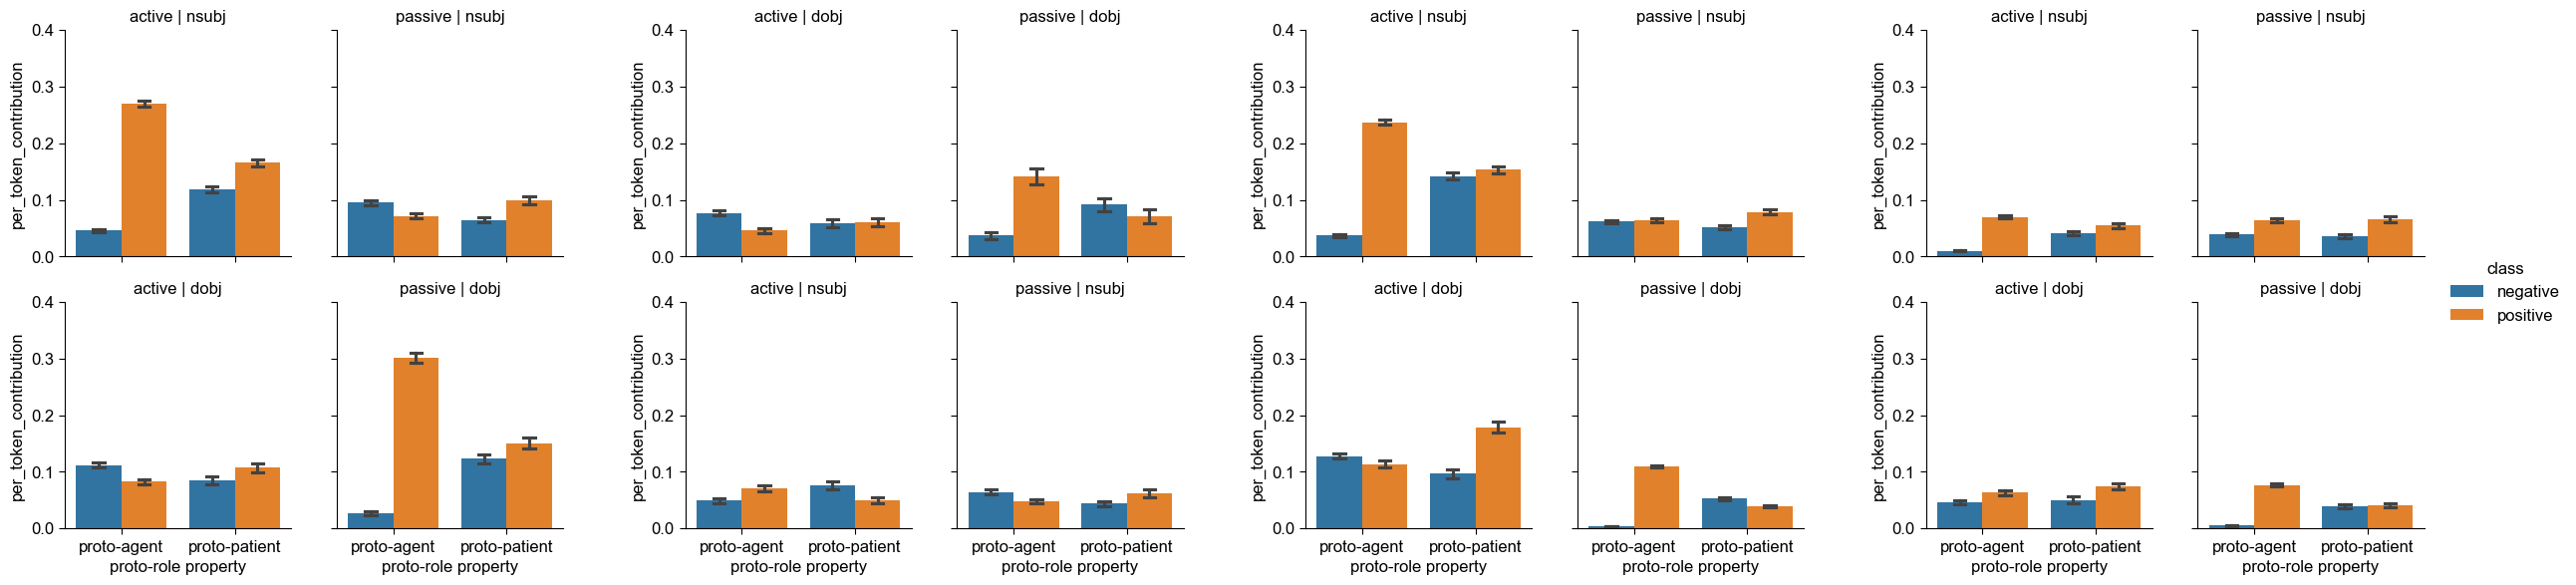

In [24]:
pw.overwrite_axisgrid()

ax1 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["span"] == "argument")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "proto-role property", y = "per_token_contribution", errorbar="se", height=2.5, capsize=0.2,
    aspect=1, legend=False)
ax1.set_titles("{col_name} | {row_name}")
ax1.set(ylim=(0, 0.4))

ax1 = pw.load_seaborngrid(ax1)

ax2 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["span"] == "modifier")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "proto-role property", y = "per_token_contribution", errorbar="se", height=2.5, capsize=0.2,
    aspect=1, legend=False)
ax2.set_titles("{col_name} | {row_name}")
ax2.set_ylabels("\nper_token_contribution")
ax2.set(ylim=(0, 0.4))

ax2 = pw.load_seaborngrid(ax2)

ax3 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["span"] == "predicate")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "proto-role property", y = "per_token_contribution", errorbar="se", height=2.5, capsize=0.2,
    aspect=1, legend=False,)

ax3.set_titles("{col_name} | {row_name}")
ax3.set_ylabels("\nper_token_contribution")
ax3.set(ylim=(0, 0.4))

ax3 = pw.load_seaborngrid(ax3)

ax4 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["span"] == "other_arguments")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "proto-role property", y = "per_token_contribution", errorbar="se", height=2.5, capsize=0.2,
    aspect=1, legend=True, legend_out=True)

ax4.set_titles("{col_name} | {row_name}")
ax4.set_ylabels("\nper_token_contribution")
ax4.set(ylim=(0, 0.4))

ax4 = pw.load_seaborngrid(ax4)

(ax1|ax2|ax3|ax4).savefig()


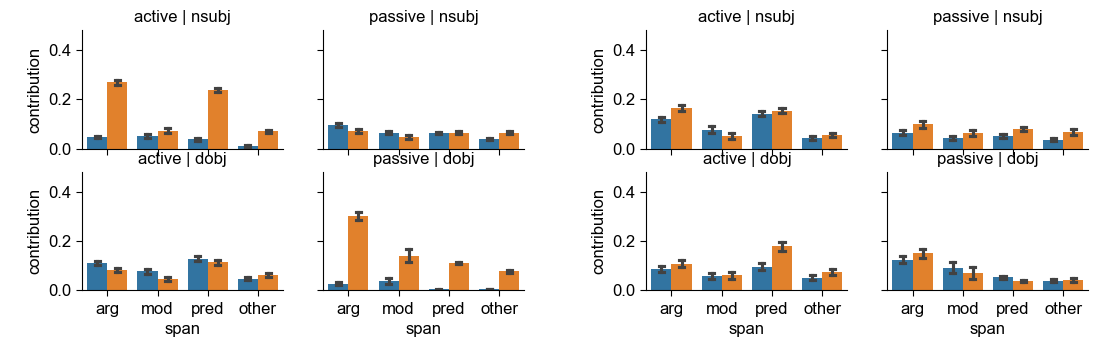

In [25]:
pw.overwrite_axisgrid()

ax1 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["proto-role property"] == "proto-agent")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "span", y = "per_token_contribution", height=1.3, capsize=0.2,
    aspect=1.7, legend=False)
ax1.set(ylim=(0, 0.48))
ax1.set_titles("{col_name} | {row_name}")
ax1.set_xticklabels(["arg", "mod", "pred", "other"])
ax1.set_ylabels("\ncontribution")
ax1.set_xlabels("span")

ax1 = pw.load_seaborngrid(ax1)

ax2 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["proto-role property"] == "proto-patient")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "span", y = "per_token_contribution", height=1.3, capsize=0.2,
    aspect=1.7, legend=False)
ax2.set_titles("{col_name} | {row_name}")
ax2.set(ylim=(0, 0.48))
ax2.set_xticklabels(["arg", "mod", "pred", "other"])
ax2.set_ylabels("\ncontribution")
ax2.set_xlabels("span")

ax2 = pw.load_seaborngrid(ax2)

(ax1|ax2).savefig()


### Bias contributions

In [30]:
binary_logits.shape


(3, 2556, 2, 10)

In [36]:
contributions_df = eval_df.copy(deep=True)

contributions_df["bias_contribution"] = (binary_logits[2] / (binary_logits.sum(0) + 1e-10)).tolist()
contributions_df[labels] = contributions_df['bias_contribution'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

contributions_df = contributions_df.melt(
    id_vars=["sentence", "index", "contribution", "gram", "structure"], value_vars=labels, value_name="logits",
    var_name="property")
contributions_df[["negative", "positive"]] = contributions_df['logits'].apply(lambda x: pd.Series(np.array(x).T.tolist()))


contributions_df["span"] = contributions_df["contribution"].apply(
    lambda x: spans["_".join(x.split("_")[:-1])])
contributions_df = contributions_df.melt(id_vars=[ "index", "sentence","span", "property", "gram", "structure"],
                      value_vars=["negative", "positive"],
                      var_name="class", value_name="bias_contribution")

# lower, upper = np.nanpercentile(contributions_df["bias_contribution"].to_numpy(), [5, 99])
# print(f"clipping outliers less than {lower} or greater than {upper}")

contributions_df["structure"] = contributions_df["structure"].apply(
    lambda x: "_".join(x.split("_")[:-1]))

contributions_df["model"] = "roberta"
contributions_df.head()


,index,sentence,span,property,gram,structure,class,bias_contribution,model
0,14299,<a>A girl<a><p> raises<p> her hand.,argument,awareness,nsubj,active,negative,-0.000000,roberta
1,14301,A girl<p> raises<p><a> her hand<a>.,argument,awareness,dobj,active,negative,-0.000000,roberta
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",argument,awareness,nsubj,active,negative,0.420499,roberta
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",argument,awareness,nsubj,active,negative,-0.000000,roberta
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",argument,awareness,nsubj,active,negative,-0.000000,roberta


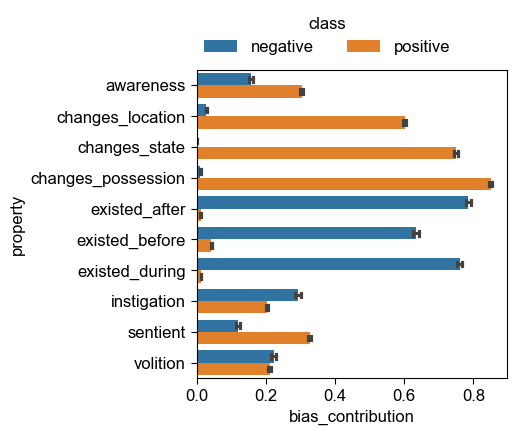

In [38]:
plt.figure(figsize=(4,4))

ax = sns.barplot(
    contributions_df.loc[contributions_df["gram"] != "iobj"], 
    hue="class", y = "property", x = "bias_contribution", errorbar="se",
    capsize=0.3)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.42, 1), ncol=3,
                title="class", frameon=False)


In [39]:
# add bias logits from GPT2

gpt_logits = []
for i in range(480):
    a = np.load(f"gcd_logits/gpt2/batch_{i}_logits.npy")
    gpt_logits.append(a)

gpt_logits = np.concatenate(gpt_logits, axis=1).reshape(3, -1, 3, 10)

# put "neutral" category into "negative"

gpt_logits[..., 0, :] += gpt_logits[..., 1, :]
positive_mask = (gpt_logits > 0).astype(int)

# put negative "positive" contributions in the negative category
# put negative "negative" contributions in the positive category

positive_logits = gpt_logits[..., 2, :] * positive_mask[..., 2, :] 
positive_logits -= gpt_logits[..., 0, :] * (1 - positive_mask[..., 0, :])

negative_logits = gpt_logits[..., 0, :] * positive_mask[..., 0, :]
negative_logits -= gpt_logits[..., 2, :] * (1 - positive_mask[..., 2, :])

assert(np.all(positive_logits >= 0))
assert(np.all(negative_logits >= 0))

gpt_binary_logits = np.stack(
    [negative_logits, positive_logits], axis=-2
)
gpt_binary_logits.shape


(3, 3193, 2, 10)

In [ ]:
gpt_contributions_df = eval_df.copy(deep=True)

gpt_contributions_df["bias_contribution"] = (gpt_binary_logits[2] / (gpt_binary_logits.sum(0) + 1e-10)).tolist()
gpt_contributions_df[labels] = gpt_contributions_df['bias_contribution'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

gpt_contributions_df = gpt_contributions_df.melt(
    id_vars=["sentence", "index", "contribution", "gram", "structure"], value_vars=labels, value_name="logits",
    var_name="property")
gpt_contributions_df[["negative", "positive"]] = gpt_contributions_df['logits'].apply(lambda x: pd.Series(np.array(x).T.tolist()))


gpt_contributions_df["span"] = gpt_contributions_df["contribution"].apply(
    lambda x: spans["_".join(x.split("_")[:-1])])
gpt_contributions_df = gpt_contributions_df.melt(id_vars=[ "index", "sentence","span", "property", "gram", "structure"],
                      value_vars=["negative", "positive"],
                      var_name="class", value_name="bias_contribution")

# lower, upper = np.nanpercentile(gpt_contributions_df["bias_contribution"].to_numpy(), [5, 99])
# print(f"clipping outliers less than {lower} or greater than {upper}")

gpt_contributions_df["structure"] = gpt_contributions_df["structure"].apply(
    lambda x: "_".join(x.split("_")[:-1]))
gpt_contributions_df["model"] = "gpt2"

gpt_contributions_df.head()


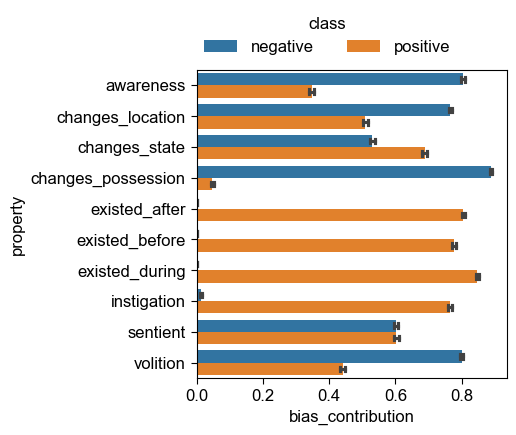

In [49]:
plt.figure(figsize=(4,4))

ax = sns.barplot(
    gpt_contributions_df.loc[gpt_contributions_df["gram"] != "iobj"], 
    hue="class", y = "property", x = "bias_contribution", errorbar="se",
    capsize=0.3)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.42, 1), ncol=3,
                title="class", frameon=False)


In [50]:
combined_bias_df = pd.concat((gpt_contributions_df, contributions_df))


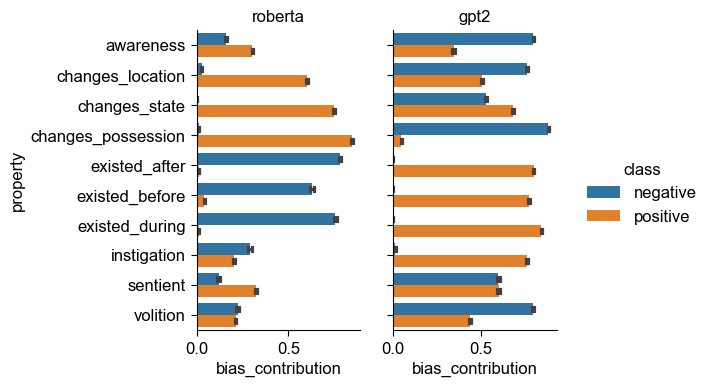

In [51]:
ax = sns.catplot(
    kind="bar", col="model", col_order=["roberta", "gpt2"],
    data=combined_bias_df.loc[combined_bias_df["gram"] != "iobj"], 
    hue="class", y = "property", x = "bias_contribution", errorbar="se",
    sharex=False, height=3, aspect=0.6,
    capsize=0.3, legend=True)
ax.set_titles("{col_name}")
# ax.axes[0, 0].set_xlim(0, 4.2)

ax = pw.load_seaborngrid(ax)
ax.savefig()


In [52]:
roles_wide


,Sentence.ID,Gram.Func,sentence,Predicate,Split,arg,Arg.Stripped,arg_idx,verb_idx,structure,decomp_version,Pred.Lemma,modified_sentence,combined_labels
0,0003_21,nsubj,"In July , a gradual ban was imposed by the Env...",was imposed by,test,a gradual ban,a ban,"(3, 6)","(6, 9)",passive_full,V1,impose,1,"[1.0, 1.0, 3.0, 1.0, 5.0, 1.0, 5.0, 1.0, 1.0, ..."
1,0003_21,dobj,"In July , a gradual ban was imposed by the Env...",was imposed by,train,the Environmental Protection Agency,the Environmental Protection Agency,"(9, 13)","(6, 9)",passive_full,V1,impose,1,"[5.0, 1.0, 3.0, 1.0, 5.0, 5.0, 5.0, 5.0, 1.0, ..."
2,0003_29,nsubj,No bearing on our work force today is had by it .,is had by,train,No bearing on our work force today,no bearing,"(0, 7)","(7, 10)",passive_full,V1,have,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,0003_29,dobj,No bearing on our work force today is had by it .,is had by,test,it,It,"(10, 11)","(7, 10)",passive_full,V1,have,1,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 3.0, 2.0, ..."
4,0003_9,nsubj,A team of researchers from the National Cancer...,was led by,train,A team of researchers from the National Cancer...,a team,"(0, 19)","(19, 22)",passive_full,V1,lead,1,"[5.0, 3.0, 3.0, 1.0, 3.0, 3.0, 5.0, 3.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28805,en-ud-train.conllu 9973,dobj,A credit card minimum is had by them .,is had by,train,them,They,"(7, 8)","(4, 7)",passive_full,V2,have,1,"[5.0, 2.5, 3.5, 2.0, 5.0, 4.0, 5.0, 5.0, 5.0, ..."
28806,en-ud-train.conllu 9995,dobj,This company was phoned by me for advice on ou...,was phoned by,train,me,I,"(5, 6)","(2, 5)",passive_full,V2,phone,1,"[5.0, 3.0, 2.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
28807,en-ud-train.conllu 9995,dobj,This company was phoned by me for advice on ou...,was phoned by,train,me,I,"(5, 6)","(2, 5)",passive_full,V2,phone,1,"[5.0, 2.0, 5.0, 2.0, 5.0, 5.0, 5.0, 5.0, 4.0, ..."
28808,en-ud-train.conllu 9995,nsubj,This company was phoned by me for advice on ou...,was phoned by,train,This company,this company,"(0, 2)","(2, 5)",passive_full,V2,phone,1,"[5.0, 2.0, 2.0, 2.0, 5.0, 5.0, 5.0, 1.0, 1.0, ..."


In [53]:
## class balances

labels_df = roles_wide.loc[
    (roles_wide["decomp_version"] == "V2") & \
    (roles_wide["Split"] == "train")].reset_index()[["combined_labels"]]

# binary labels
# labels_df[labels] = labels_df["combined_labels"].apply(lambda x: (np.array(x) ).astype(int)).to_list()
labels_df[labels] = labels_df["combined_labels"].apply(lambda x: (np.array(x) > 3).astype(int) - (np.array(x) <= 3).astype(int)).to_list()

labels_df.drop(columns="combined_labels", inplace=True)

labels_df


,awareness,changes_location,changes_state,changes_possession,existed_after,existed_before,existed_during,instigation,sentient,volition
0,1,-1,-1,-1,1,-1,1,1,1,1
1,1,-1,-1,-1,1,1,1,1,1,1
2,-1,-1,-1,-1,1,1,1,1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,1,-1,-1,-1,1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
11890,1,-1,1,-1,1,1,1,1,1,1
11891,1,-1,-1,1,1,1,1,1,1,1
11892,1,-1,1,-1,1,1,1,1,1,1
11893,1,-1,-1,-1,1,1,1,-1,-1,1


In [54]:
cols = []
a = labels_df.to_numpy()
for i in range(len(labels)):
    cols.append([a[:, i].tolist()])

balances = pd.DataFrame(cols, columns=["positive_preference"])
balances.index = labels
balances = balances.reset_index(names="property").explode(column=["positive_preference"])
balances["model"] = "training dataset"


# balances = pd.DataFrame(cols, columns=["negative", "positive"])
# balances.index = labels
# balances = balances.reset_index(names="property").explode(column=["negative", "positive"])
# balances["positive_preference"] = balances["positive"] - balances["negative"] 
# balances = balances.drop(columns=["positive", "negative"])
# balances["model"] = "dataset"


In [55]:
balances


,property,positive_preference,model
0,awareness,1,training dataset
0,awareness,1,training dataset
0,awareness,-1,training dataset
0,awareness,-1,training dataset
0,awareness,-1,training dataset
...,...,...,...
9,volition,1,training dataset
9,volition,1,training dataset
9,volition,1,training dataset
9,volition,1,training dataset


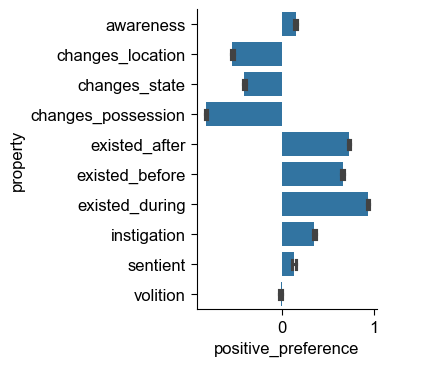

In [56]:
ax = sns.catplot(balances, y="property", x="positive_preference", orient="h",
            height=3, aspect=0.6, kind="bar", capsize=0.3)

ax = pw.load_seaborngrid(ax)
ax.savefig()


In [57]:
combined_bias_df


,index,sentence,span,property,gram,structure,class,bias_contribution,model
0,14299,<a>A girl<a><p> raises<p> her hand.,argument,awareness,nsubj,active,negative,1.000000,gpt2
1,14301,A girl<p> raises<p><a> her hand<a>.,argument,awareness,dobj,active,negative,0.915725,gpt2
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",argument,awareness,nsubj,active,negative,0.892176,gpt2
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",argument,awareness,nsubj,active,negative,1.000000,gpt2
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",argument,awareness,nsubj,active,negative,1.000000,gpt2
...,...,...,...,...,...,...,...,...,...
38335,21896,<a>The animations<a><p> were enjoyed by<p> me ...,predicate,volition,nsubj,passive,positive,0.101801,roberta
38336,21898,<a>A Full Color Catalog and Wholesale Price Li...,predicate,volition,nsubj,passive,positive,0.120910,roberta
38337,21900,A Full Color Catalog and Wholesale Price List ...,predicate,volition,dobj,passive,positive,0.238826,roberta
38338,21902,"<a>Visa, MasterCard, Amex, Dinners Club/Carte ...",predicate,volition,nsubj,passive,positive,0.401174,roberta


In [58]:
preferences = combined_bias_df[["property", "class", "bias_contribution", "model"]]

preferences = preferences.pivot_table(index=["property", "model"], columns="class", values="bias_contribution", aggfunc=list).explode(column=["negative", "positive"])

preferences["positive_preference"] = preferences["positive"] - preferences["negative"]
preferences = preferences.drop(columns=["negative", "positive"]).reset_index()

preferences


class,property,model,positive_preference
0,awareness,gpt2,-0.741705
1,awareness,gpt2,-0.654334
2,awareness,gpt2,-0.496077
3,awareness,gpt2,-0.929544
4,awareness,gpt2,-0.912301
...,...,...,...
38335,volition,roberta,-0.017091
38336,volition,roberta,0.09103
38337,volition,roberta,0.238826
38338,volition,roberta,0.401174


In [59]:
preferences = pd.concat([preferences, balances]).reset_index(drop=True)
preferences


,property,model,positive_preference
0,awareness,gpt2,-0.741705
1,awareness,gpt2,-0.654334
2,awareness,gpt2,-0.496077
3,awareness,gpt2,-0.929544
4,awareness,gpt2,-0.912301
...,...,...,...
157285,volition,training dataset,1
157286,volition,training dataset,1
157287,volition,training dataset,1
157288,volition,training dataset,1


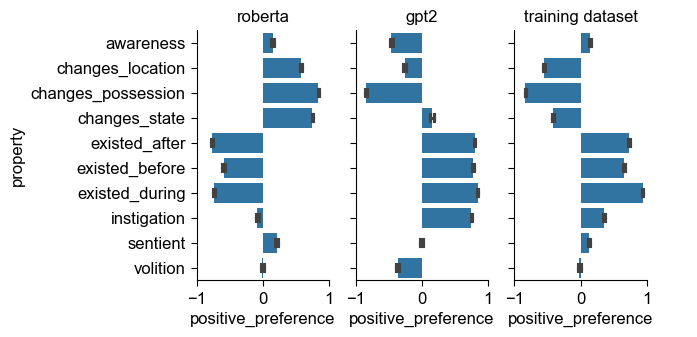

In [60]:
ax = sns.catplot(
    kind="bar", col="model", col_order=["roberta", "gpt2", "training dataset"],
    data=preferences, y = "property", x = "positive_preference",
    sharex=False, height=2.5, aspect=0.6, legend=True, capsize=0.3)
ax.set_titles("{col_name}")
ax.axes[0, 0].set_xlim(-1, 1)
ax.axes[0, 1].set_xlim(-1, 1)
ax.axes[0, 2].set_xlim(-1, 1)

ax = pw.load_seaborngrid(ax)
ax.savefig()
